In [99]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
from Dataset import LOBDataset
from utils import weighted_pearson_correlation

In [100]:
BASE_DIR = Path.cwd()

In [101]:
train_dataset_file = BASE_DIR / "datasets/train.parquet"
test_dataset_file = BASE_DIR / "datasets/valid.parquet"
learning_rate = 1e-4
nepochs = 100
batch_size = 40

In [102]:
##sequence dimension
n_steps = 1000

In [103]:
dataset_train = LOBDataset(train_dataset_file, n_steps=n_steps, labels=['t0', 't1'])
dataset_test = LOBDataset(test_dataset_file,n_steps=n_steps, labels=['t0', 't1'])

In [104]:
print(f'Number of training sequences: {dataset_train.__n_sequences__()}')
print(f'Number of testing sequences: {dataset_test.__n_sequences__()}')

Number of training sequences: 10721
Number of testing sequences: 1444


In [105]:
print(f'Number of training steps: {len(dataset_train)}')
print(f'Number of testing steps: {len(dataset_test)}')

Number of training steps: 1000
Number of testing steps: 1000


In [106]:
#df = pd.read_parquet(train_dataset_file, engine='pyarrow')
#df.set_index(['seq_ix', 'step_in_seq', 'need_prediction'], inplace=True)

In [107]:
#features_normalized = (df.groupby(level=0).apply(lambda x: (x - x.mean()) / x.std()))

In [108]:
#features_normalized.reset_index(level=0, drop=True, inplace=True)
#features_normalized.shape

In [109]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=False, drop_last=False)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [110]:
# Define our network class using nn.Module
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Define layers for the MLP block
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size) ##reduce complexity divide by 2
        self.norm2 = nn.LayerNorm(input_size)
        self.fc2 = nn.Linear(input_size, output_size) ##reduce complexity divide by 2
        self.fc3 = nn.Linear(input_size, output_size)
        self.act = nn.ELU() #elementwise relu

    def forward(self, x):
        # Forward pass through the MLP block
        x = self.act(self.norm1(x))
        skip = self.fc3(x)  # Skip connection
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        return x + skip

In [111]:
class LSTM(nn.Module):
    def __init__(self, n_features,  output_size, num_blocks=1, num_layers=2, hidden_size=128):
        super(LSTM, self).__init__()
        # Define layers for input MLP, LSTM, residual blocks, and output linear layer
        self.input_mlp = nn.Sequential(nn.Linear(n_features, hidden_size), #expand size 
                                       nn.ELU(),
                                       nn.Linear(hidden_size, hidden_size))
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.act = nn.ELU()
    
    def forward(self, input_seq, hidden_in, mem_in):
        # Pass input sequence through the input MLP
        input_vec = self.input_mlp(input_seq)
        
        # Pass the input MLP output through the LSTM block
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))
        
        # Pass the LSTM output through residual blocks
        x = self.act(self.res_blocks(output))
        
        # Pass the output of the residual blocks through the final linear layer
        return self.fc_out(x), hidden_out, mem_out

In [112]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

hidden_size = 128

# Create the LSTM model
lob_lstm = LSTM(n_features=32, output_size=2, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam and specified learning rate
optimizer = optim.Adam(lob_lstm.parameters(), lr=learning_rate)

# Define the loss function as Mean Squared Error
loss_fn = nn.MSELoss()

# Initialize a list to log training losses
training_loss_logger = []

In [113]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lob_lstm.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 335234 (Approximately 0 Million) Parameters!


In [ ]:
# Run training loop for each epoch
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    lob_lstm.train()

    for seq_id, data_seq in tqdm(data_loader_train, desc='Training', leave=False):
        
        # last two columns are labels
        seq_block = data_seq[:,:,:-2].to(device)
        target_seq_block = data_seq[:,:,-2:].to(device)

        hidden = torch.zeros(2, data_seq.shape[0], hidden_size, device=device)
        memory = torch.zeros(2, data_seq.shape[0], hidden_size, device=device)
        
        data_pred, hidden, memory = lob_lstm(seq_block, hidden, memory)

        loss = loss_fn(data_pred, target_seq_block)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
len(training_loss_logger)

2500

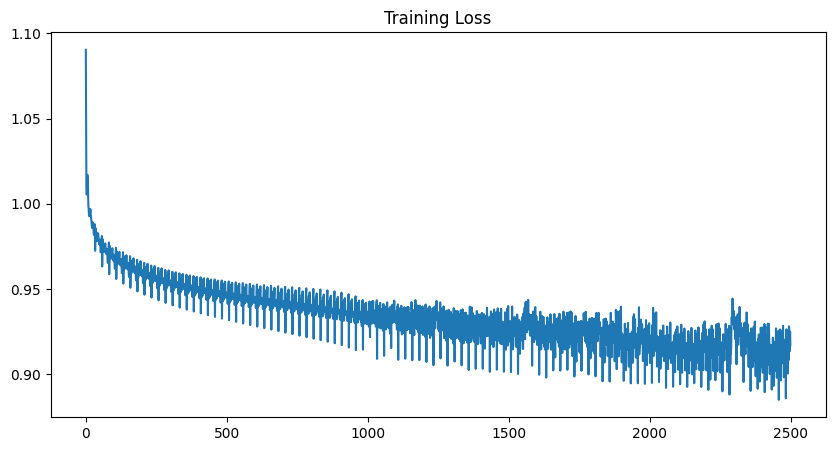

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [ ]:
# Convert test dataset to tensor
data_tensor = dataset_test.dataset
log_predictions = []
lob_lstm.eval()

with torch.no_grad():

    seq_block = data_tensor[:, :, :-2].to(device) #(n_seq, seq_len, n_features)
    batch_size = seq_block.shape[0]

    hidden = torch.zeros(2, batch_size, hidden_size, device=device) #1, n_seq, hidden_szie
    memory = torch.zeros(2, batch_size, hidden_size, device=device) #1, n_seq, hidden_size
    

    data_pred, _, _ = lob_lstm(seq_block, hidden, memory) #n_seq, seq_len, output_size

    log_predictions = data_pred.cpu()
    



In [ ]:
y_pred = log_predictions.detach().cpu().numpy()
y_true = data_tensor[:, :, -2:].detach().cpu().numpy()

In [ ]:
weighted_pearson_correlation(y_true, y_pred)

0.30547595024108887